# Chuẩn bị

In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## Đọc ảnh

Bước phân chia vùng ảnh này chỉ đang chia bằng trực quan

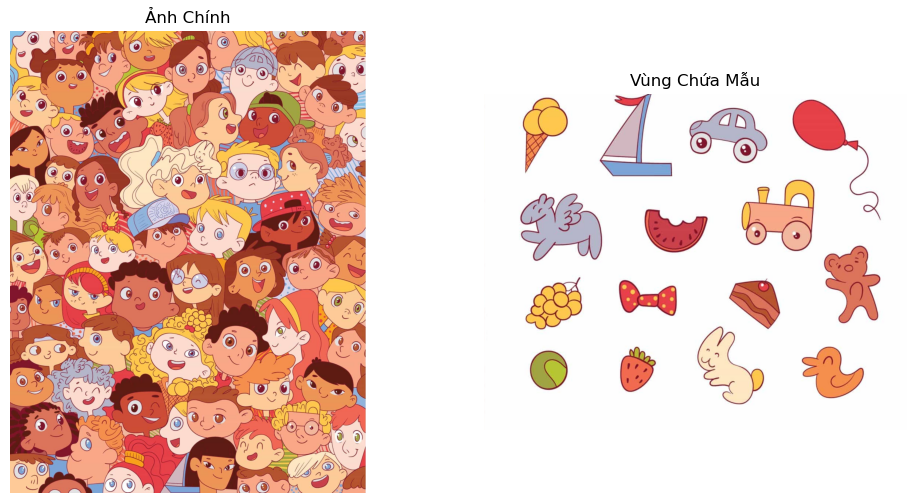

In [17]:
image_path = "1.jpg"
image = cv2.imread(image_path)
height, width = image.shape[:2]

split_ratio = 0.45 
main_image = image[:, :int(width * (1 - split_ratio))]
template_region = image[:, int(width * (1 - split_ratio)):] 
template_region = template_region[int(template_region.shape[0]/2):, :]

cv2.imwrite("main_image.jpg", main_image)
cv2.imwrite("template_region.jpg", template_region)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Ảnh Chính")
ax[0].axis("off")

ax[1].imshow(cv2.cvtColor(template_region, cv2.COLOR_BGR2RGB))
ax[1].set_title("Vùng Chứa Mẫu")
ax[1].axis("off")

plt.show()

## Tách mẫu

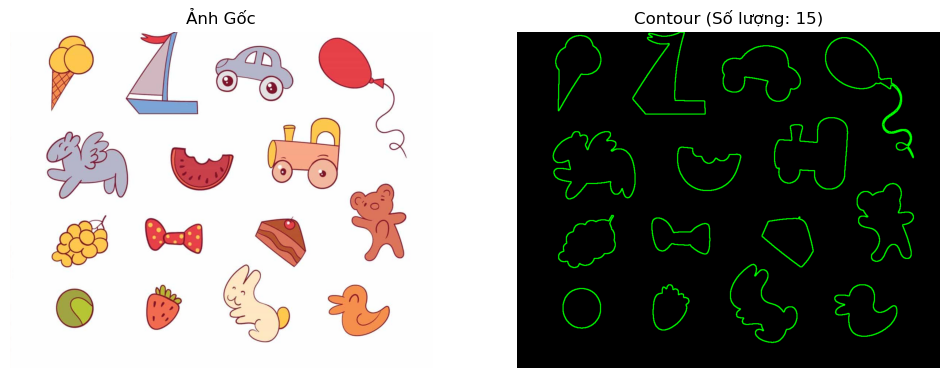

In [18]:
gray = cv2.cvtColor(template_region, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Hiển thị ảnh gốc và ảnh có contour
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Hiển thị ảnh gốc
ax[0].imshow(cv2.cvtColor(template_region, cv2.COLOR_BGR2RGB))
ax[0].set_title("Ảnh Gốc")
ax[0].axis("off")

# Hiển thị ảnh có contour
contour_img = np.zeros_like(template_region)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
ax[1].imshow(contour_img)
ax[1].set_title(f"Contour (Số lượng: {len(contours)})")
ax[1].axis("off")

plt.show()

### Save templates

In [19]:
output_folder = "templates"
os.makedirs(output_folder, exist_ok=True)

# Cắt từng mẫu và lưu
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 30 and h > 30:  # Loại bỏ các phần quá nhỏ
        filtered_contours.append(contour)

for i, contour in enumerate(filtered_contours):
    white_bg = np.ones_like(template_region) * 255

    # Tạo mask
    mask = np.zeros(template_region.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, (255), -1)
    
    # Áp dụng mask
    obj = cv2.bitwise_and(template_region, template_region, mask=mask)
    bg = cv2.bitwise_and(white_bg, white_bg, mask=cv2.bitwise_not(mask))
    sample = obj + bg
    
    # Lấy vùng quan tâm
    x, y, w, h = cv2.boundingRect(contour)
    sample = sample[y:y+h, x:x+w]
    cv2.imwrite(f"{output_folder}/sample_{i}.png", sample)

print(f"Đã lưu {len(filtered_contours)} mẫu vào thư mục {output_folder}")

Đã lưu 15 mẫu vào thư mục templates


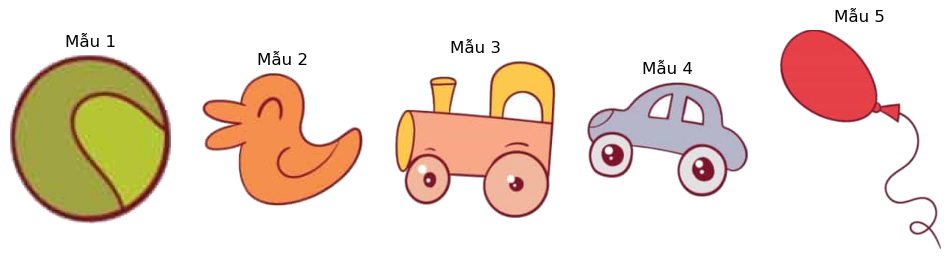

In [20]:
samples = os.listdir(output_folder)
fig, axes = plt.subplots(1, min(5, len(samples)), figsize=(12, 6))

for i, sample_file in enumerate(samples[:5]): 
    sample_path = os.path.join(output_folder, sample_file)
    sample_img = cv2.imread(sample_path)
    axes[i].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Mẫu {i+1}")
    axes[i].axis("off")

plt.show()

# Template Matching

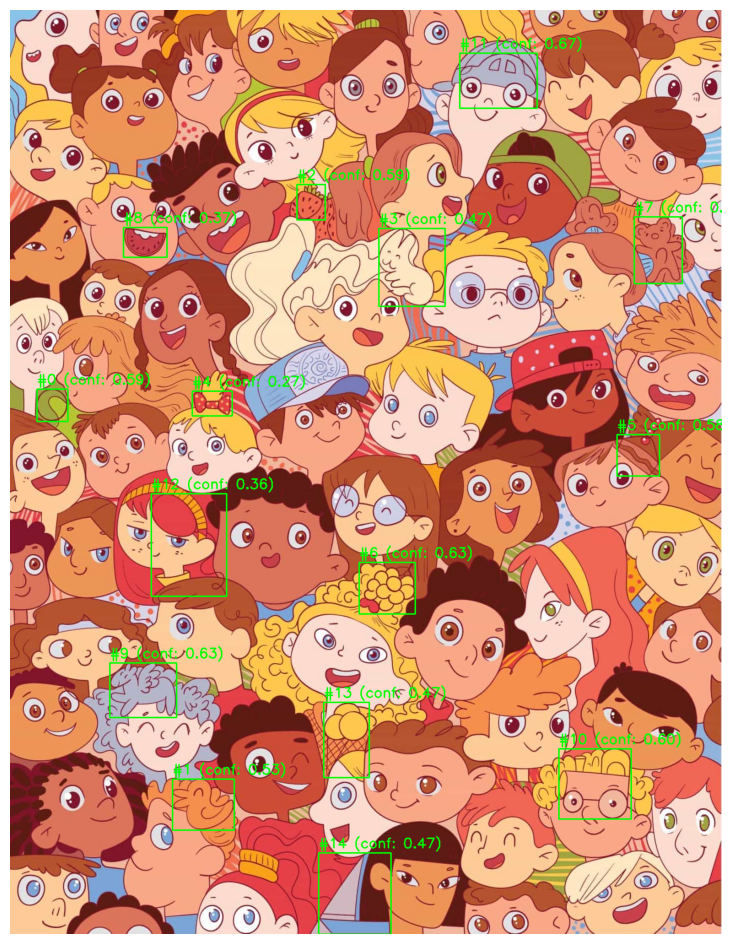

In [ ]:
gray_main = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
gray_main = cv2.Canny(gray_main, 50, 150)
template_folder = "templates"
template_images = [f for f in os.listdir(template_folder) if f.endswith(".png")]
result_image = main_image.copy()

# Định nghĩa khoảng scale
scale_range = np.linspace(0.5, 1, 100)

for template_file in template_images:
    template_path = os.path.join(template_folder, template_file)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    template_number = int(''.join(filter(str.isdigit, template_file)))
    
    best_location = None
    best_scale = 1.0
    max_confidence = -1
    
    # Thử với các tỷ lệ khác nhau
    for scale in scale_range:
        # Tính kích thước mới
        width = int(template.shape[1] * scale)
        height = int(template.shape[0] * scale)
        
        # Resize template
        resized_template = cv2.resize(template, (width, height), interpolation=cv2.INTER_LINEAR)
        
        # Thực hiện template matching
        # Canny
        resized_template = cv2.Canny(resized_template, 50, 150)

        match_result = cv2.matchTemplate(gray_main, resized_template, cv2.TM_CCOEFF_NORMED)

        # Tìm vị trí có độ tương đồng cao nhất
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)
        
        # Cập nhật nếu tìm thấy kết quả tốt hơn
        # if max_val > max_confidence and max_val >= threshold:
        if max_val > max_confidence:
            max_confidence = max_val
            best_scale = scale
            best_location = (max_loc[0], max_loc[1], width, height)
    
    # Vẽ kết quả với vị trí tốt nhất
    if best_location is not None:
        x, y, w, h = best_location
        # Vẽ khung chữ nhật
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Hiển thị thông tin
        text = f"#{template_number} (conf: {max_confidence:.2f})"
        cv2.putText(result_image, text, (x, y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

cv2.imwrite("result_image.jpg", result_image)
fig, ax = plt.subplots(figsize=(24, 12))
ax.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()